In [216]:
from mvlearn.embed.kcca import KCCA
from mvlearn.embed.dcca import DCCA
from mvlearn.embed.gcca import GCCA

from mvlearn.datasets.GaussianMixture import GaussianMixture
%load_ext autoreload
%autoreload 2

import numpy as np
import collections
import matplotlib.pyplot as plt
from graspy.plot import pairplot
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Point Distribution

In [247]:
## Training
n = 200
mu = [[0,1], [0,-1]]
sigma = 10*[np.eye(2), np.eye(2)]
pi = [0.5,0.5]
GM = GaussianMixture(n,mu,sigma,class_probs=pi)

## Test
GM2 = GaussianMixture(n,mu,sigma,class_probs=pi)

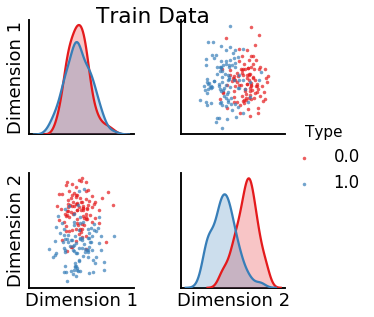

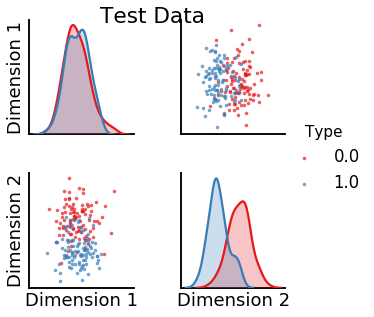

In [248]:
pairplot(GM.latent, GM.y, title='Train Data')
pairplot(GM2.latent, GM2.y, title='Test Data')

## Latent Plotted against itself (ground truth)

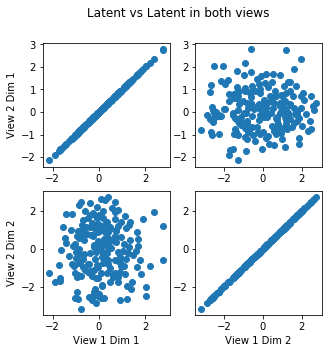

In [249]:
GM.plot_latents(title='Latent vs Latent in both views')

In [253]:
def plot_components(components, method, transformation, labels=None):
    # We plot dimensions of both views to further show that the first two dimensions are linearly correlated ideally
    n_dim = components[0].shape[1]
    fig,axes = plt.subplots(n_dim,n_dim,figsize=(8,8))
    for i,ax in enumerate(axes.flatten()):
        dim2 = int(i/n_dim)
        dim1 = i % n_dim
        if not labels is None:
            ax.scatter(components[0][:,dim1],components[1][:,dim2], c=labels, alpha=0.2)
        else:
            ax.scatter(components[0][:,dim1],components[1][:,dim2])
        if dim2 == n_dim-1:
            ax.set_xlabel(f'View 1 Component {dim1+1}')
        if dim1 == 0:
            ax.set_ylabel(f'View 2 Component {dim2+1}')
        ax.axis('equal')
        #ax.set_xticks([])

    plt.suptitle(f'{method} o {transformation} Transform')
    plt.show()

def compare_methods(transform, n_noise=2):
    # Create train/test 2 views. Different data but same seeded transform
    GM.sample_views(transform=transform, n_noise=n_noise, random_states=[1,2])
    GM2.sample_views(transform=transform, n_noise=n_noise, random_states=[3,4])
    
    # Plot 2 views of training data
    GM.plot_2views(title=f'{transform} Transformation of Latents', figsize=(8,8))

    # KCCA Methods
    ktypes = ['linear', 'poly', 'gaussian']
    for ktype in ktypes:
        kcca = KCCA(ktype=ktype, reg = 10.0, n_components = GM.Xs[0].shape[1])
        components = kcca.fit(GM.Xs).transform(GM.Xs)
        plot_components(components, ktype + ' KCCA', transform)    
        
    # DCCA
    input_size1, input_size2 = GM.Xs[0].shape[1], GM.Xs[1].shape[1]
    outdim_size = min(GM.Xs[0].shape[1], 4)
    layer_sizes1 = [1024, outdim_size]
    layer_sizes2 = [1024, outdim_size]
    dcca = DCCA(input_size1, input_size2, outdim_size, layer_sizes1, layer_sizes2, epoch_num=100, threshold=0.001)#, print_train_log_info=True)
    dcca = dcca.fit(GM.Xs)
    outputs = dcca.transform(GM2.Xs)
    plot_components(outputs, 'Deep CCA', transform)  

## Testing KCCA

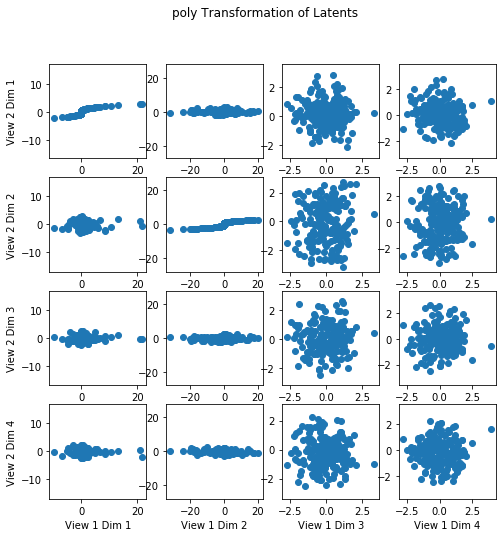

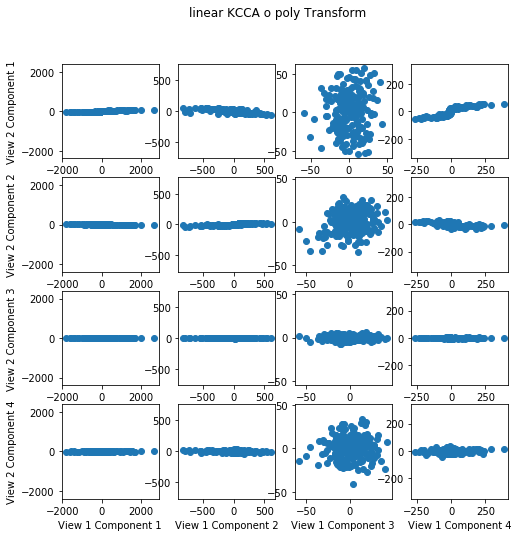

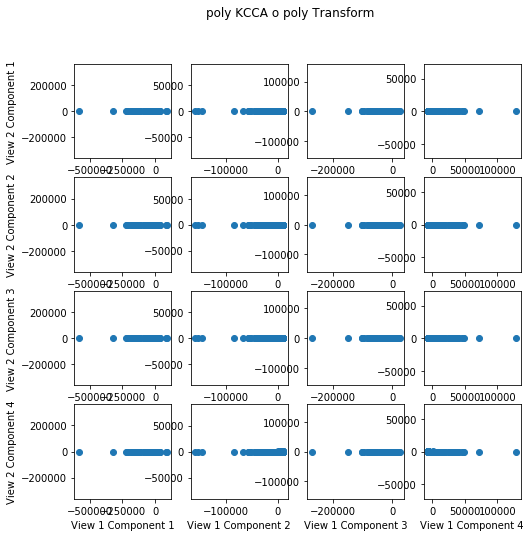

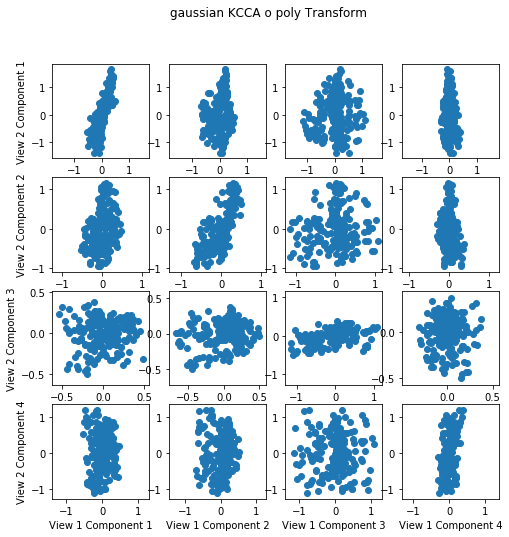

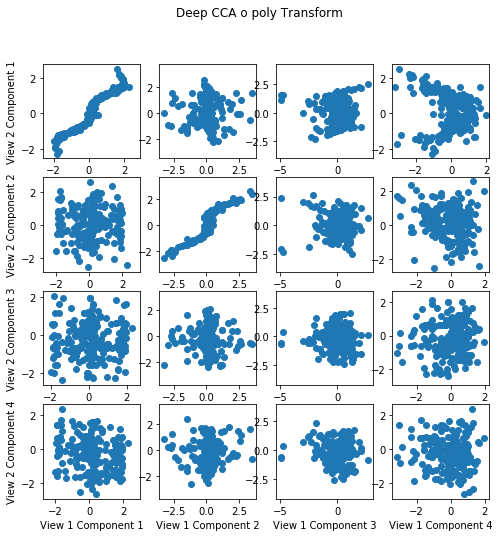

In [255]:
compare_methods('poly')

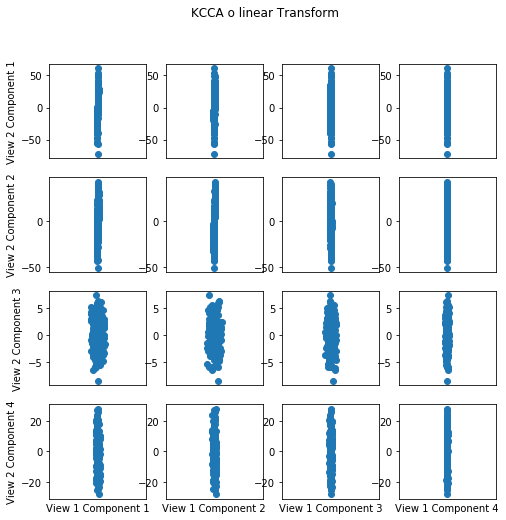

In [208]:
kcca = KCCA(ktype='gaussian', reg = 1.0, n_components = 4, test=True)
components = kcca.fit(GM.Xs).transform(GM2.Xs)

plot_components(components, 'KCCA', transform)   

In [212]:
KCCA

mvlearn.embed.kcca_experimental.KCCA

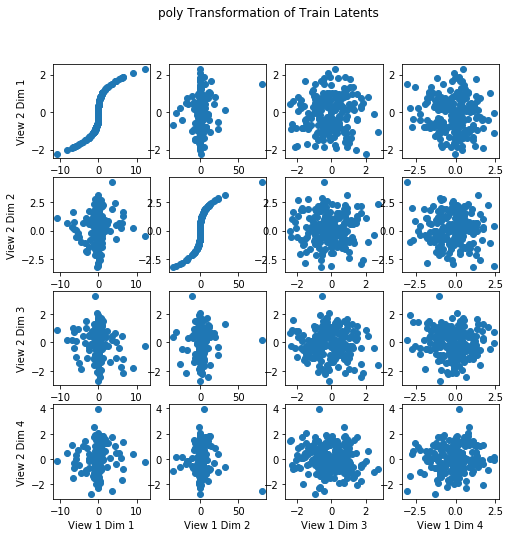

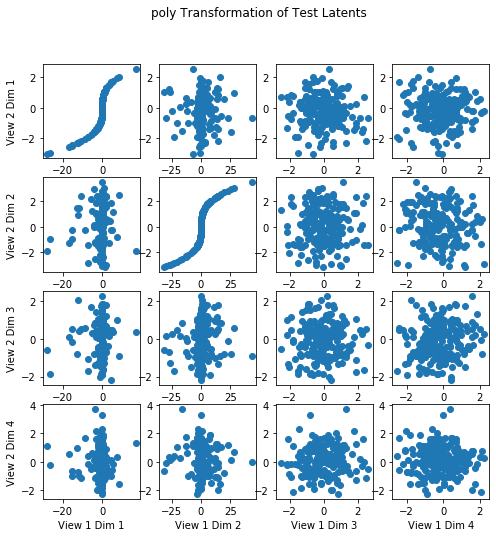

In [150]:
n_noise = 2
transform='poly'
GM.sample_views(transform=transform, n_noise=n_noise, random_states=[0,1])
GM2.sample_views(transform=transform, n_noise=n_noise, random_states=[2,3])

# Plot 2 views of training data
GM.plot_2views(title=f'{transform} Transformation of Train Latents', figsize=(8,8))
GM2.plot_2views(title=f'{transform} Transformation of Test Latents', figsize=(8,8))

## Paper figure

In [2]:
import math

In [3]:
angles = np.random.uniform(0,2*math.pi,100)

In [4]:
X1 = np.asarray([[2 * math.cos(a), 2 * math.sin(a)] for a in angles])# + np.random.normal(0,0.1,size=(100,2))
X2 = np.asarray([[a - math.pi, math.sin(a)] for a in angles])# + np.random.normal(0,0.1,size=(100,2))

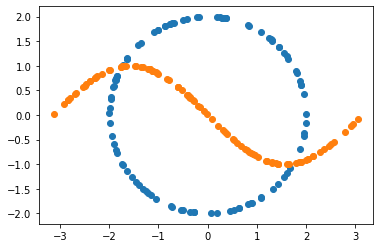

In [5]:
plt.scatter(X1[:,0], X1[:,1])
plt.scatter(X2[:,0], X2[:,1])
plt.axis('equal')
plt.show()

In [176]:
kcca = KCCA(ktype2='poly', ktype='gaussian', reg = 0.00001, n_components=3, constant=math.pi, test=True, sigma=1.0, degree=2.0)
components = kcca.fit([X1, X2]).transform([X1, X2])

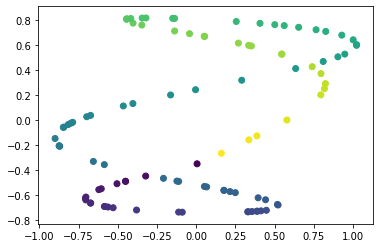

In [177]:
plt.scatter(components[0][:,0], components[1][:,0], c=angles)

In [180]:
from mpl_toolkits.mplot3d import Axes3D

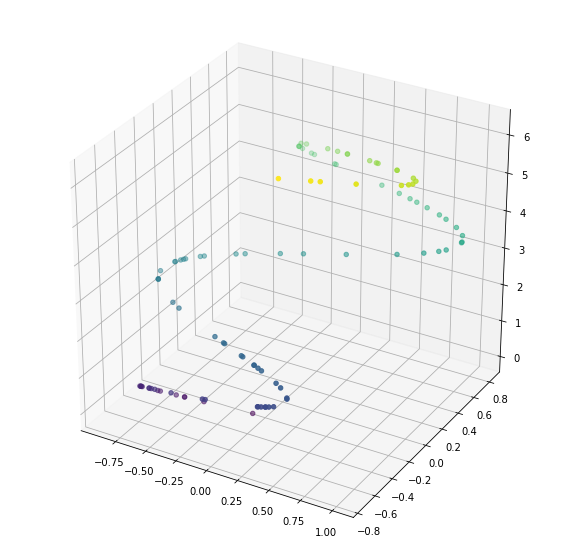

In [181]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=components[0][:,0], ys=components[1][:,0], zs=angles, c=angles)
plt.show()

## Paper data

In [257]:
def make_data(kernel, N):
    # # # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(N,)
    latvar2 = np.random.randn(N,)
    
    # # # Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]

In [263]:
sample_data = make_data('poly', N=100)

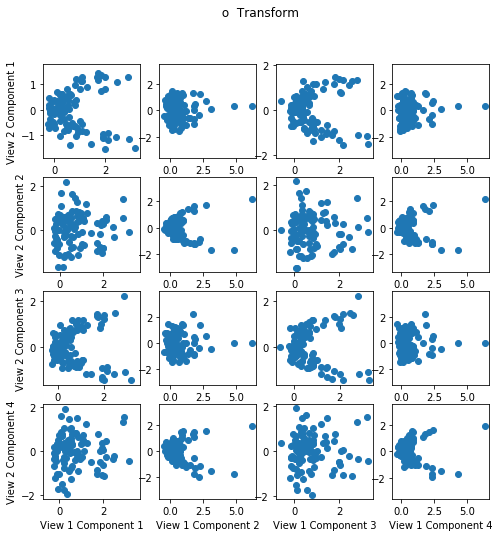

In [264]:
plot_components(sample_data, '', '')